![](https://mp.weixin.qq.com/s/032Ywb8PCGlvCEYvt5qlkA)
[The hacker's guide to uncertainty estimates](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html)

In [1]:
import numpy
import random
import datetime

In [4]:
def generate_time_series(k=200,m=1000,sigma=100,n=50,
                        start_date=datetime.date(2017,7,1)):
    xs = numpy.linspace(0,1,n,endpoint = False)
    ys = [k*x + m + random.gauss(0,sigma) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    x_scale = numpy.linspace(-1,2,500)
    t_scale = [start_date + datetime.timedelta(x)*365 for x in x_scale]
    return xs,ys,ts,x_scale,t_scale

xs,ys,ts,x_scale,t_scale = generate_time_series()

Text(0, 0.5, 'Weight of elephant(kg)')

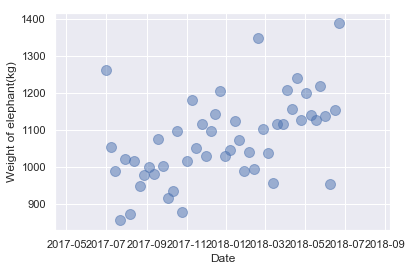

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.scatter(ts,ys,alpha=0.5,s=100)
plt.xlabel('Date')
plt.ylabel('Weight of elephant(kg)') 

> 数据分布与不确定性

之前我一直搞不清“不确定性”的意思，但我认为搞清楚这一点非常重要。我们可以为多种不同的数据估算分布：

1. 数据本身。给定一定的时间范围（t ，t '），在这个时间间隔内大象体重的分布是什么？

2. 某些参数的不确定性。如参数k在线性关系y = k t + m里，或者某些估算器的不确定性，就像许多观测值的平均值一样。

3. 预测数值的不确定性。因此，如果我们预测日期为t（可能在未来）时大象的重量是y公斤，我们想知道数量y的不确定性。

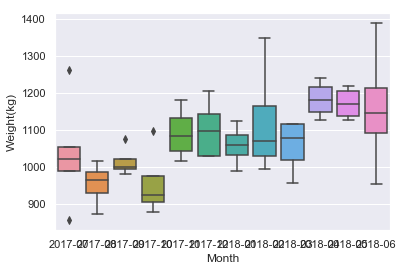

In [18]:
import pandas as pd
d = pd.DataFrame({'x':xs,'t':ts,'Weight(kg)':ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
sns.boxplot(data=d,x='Month',y='Weight(kg)')

`计算均值的不确定性 - 正态分布`

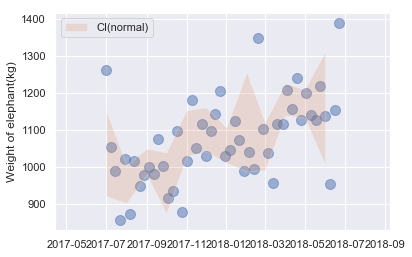

In [31]:
def plot_CI(obs_by_group):
    groups = list(sorted(obs_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = obs_by_group[group]
        mu,std,n = numpy.mean(series),numpy.std(series),len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups,lo_bound,hi_bound,alpha=0.2,label='CI(normal)')

plt.scatter(ts,ys,alpha=0.5,s=100)
obs_by_month = {}
for month,y in zip(d['Month'],d['Weight(kg)']):
    obs_by_month.setdefault(month,[]).append(y)

plot_CI(obs_by_month)
plt.ylabel('Weight of elephant(kg)')
plt.legend()

`所有结果为0或1时的置信区间`

In [36]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    output = {}
    e_obs_per_state = numpy.random.exponential(k,size=len(states))
    state_bias = numpy.random.normal(b,b_std,size=len(states))
    for groups,z in zip(groups,zs):
        noise = numpy.random.normal(z,z_std,size=len(states))
        ps = 1 / (1 + numpy.exp(-(state_bias + noise)))
        ns =numpy.random.poisson(e_obs_per_state)
        ks = numpy.random.binomial(ns,ps)
        output[groups] = (ns,ks)
    return output

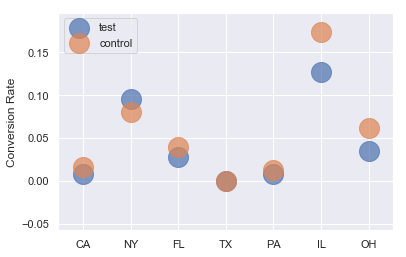

In [37]:
data = generate_binary_categorical()
for group, (ns,ks) in data.items():
    plt.scatter(STATES,ks/ns,label=group,alpha=0.7,s=400)
plt.ylabel("Conversion Rate")
plt.legend()

```python

n, k = 100, 3

scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])
```

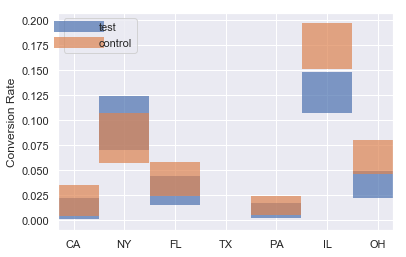

In [39]:
import scipy as scipy

for group,(ns,ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025,ks,ns-ks)
    hi = scipy.stats.beta.ppf(0.975,ks,ns-ks)
    mean = ks/ns
    plt.errorbar(STATES,y=mean,yerr = [mean-lo,hi-mean],
                label=group,alpha=0.7,linewidth=0,elinewidth=50)
    
plt.ylabel('Conversion Rate')
plt.legend()

`TBD`
Some example of A/B test from Book [Tableau商业分析从新手到高手](https://www.amazon.cn/dp/B07D55HVL3/ref=sr_1_2?ie=UTF8&qid=1544511736&sr=8-2&keywords=tableau)


In [51]:
import sys,os
os.getcwd()
os.chdir('C:\\Users\\randa\\Desktop\\JupyterNote\\Python\\PyPrac\\第10章')

In [82]:
import numpy as np
import pandas as pd

df_sales = pd.read_csv(r'sales.csv',encoding = 'utf-8')
df_test = pd.read_excel(r'test.xlsx',encoding='utf-8')
df = pd.merge(df_sales,df_test,on='Store_ID')
df.head()

,Store_ID,Week_Ending,Gross_Rev,Test_label,Group_label,Test_duration
0,S001,2010/1/2,59685.01,0,NaN,0
1,S001,2010/1/9,24946.82,0,NaN,0
2,S001,2010/1/16,26096.93,0,NaN,0
3,S001,2010/1/23,24475.04,0,NaN,0
4,S001,2010/1/30,29825.45,0,NaN,0


In [119]:
df['Week_Ending'] = pd.to_datetime(df['Week_Ending'])
df['Test_duration'] = np.where(df['Week_Ending']>'2011-10-08',1,0)

In [120]:
df[df['Test_label']==1].pivot_table(values='Gross_Rev',index='Store_ID',columns='Test_duration')

Test_duration,0,1
Store_ID,,
S027,73080.882581,87441.343478
S029,65101.063333,72233.871739
S035,55056.898065,59192.042174
S037,57839.269462,72874.807826
S044,62104.330108,72869.933913
S049,58574.878925,62091.186087
S063,52720.998817,57876.811304
S073,72112.395054,78429.596087
S082,60403.125376,69726.891739


In [122]:
# df[df['Test_label']==1].groupby(['Store_ID', 'Test_duration'])['Gross_Rev'].aggregate('mean').unstack()

In [124]:
plt_1 = df[df['Test_label']==1].pivot_table(values='Gross_Rev',index=['Store_ID','Test_duration'])
plt_1 = pd.DataFrame(plt_1)
plt_1 = plt_1.reset_index(level=['Store_ID','Test_duration'])
plt_1.head()

,Store_ID,Test_duration,Gross_Rev
0,S027,0,73080.882581
1,S027,1,87441.343478
2,S029,0,65101.063333
3,S029,1,72233.871739
4,S035,0,55056.898065


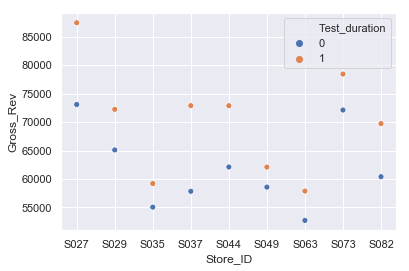

In [125]:
%matplotlib inline
# import matplotlib.pyplot as plt
import seaborn as sns; sns.set

sns.scatterplot(x='Store_ID',y='Gross_Rev',data=plt_1, hue='Test_duration')